In [44]:
%matplotlib inline 
import math
import matplotlib.pyplot as plt
import re 
import numpy as np
import os
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf
from pyspark.sql.functions import mean, stddev
from scipy.sparse import coo_matrix
import json
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import udf
import re
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.mllib.evaluation import BinaryClassificationMetrics, RegressionMetrics
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [4]:
spark = SparkSession.builder.master('local[100]').appName("zillow").getOrCreate()
df = spark.read.csv('/project/cmsc25025/zillow/zillow-train.csv', header=True)

In [4]:
df.count()

186180

Explore the data to learn what the different predictor variables are, and what their
distribution looks like. Make plots of these distributions. Some of the variables are
categorical—how many values do they take? When you plot the variables, including
the response SalePrice, does it appear that the data are “raw” or that they have been
preprocessed in different ways? How?

As you can see below, the categorical variable take a variable number of values. The Categorical MSA takes 4, the City takes 1,344 and the High School takes 774. You could also consider BuiltYear and BuiltDecade as categorical in which case they take 205 and 32 values respectively

In [4]:
for col in df.columns:
    print col, df.select(col).distinct().count()

ID 185971
Lat 166978
Long 167934
ListPrice 7674
SaleYear 9
Bathroom 10
Bedroom 8
BuiltYear 205
BuildDecade 32
MajorRenov 118
FinishSqFt 7161
LotSqFt 15343
MSA 4
City 1344
HighSchool 774
SalePrice 8267


When you plot the frequency distribution of the data you start seeing some interesting patterns, for instance, in the case of Sale Price the distribution is slightly skewed to the left. There also appears to be some homes which are worth 15,000 dollars which definitely sounds a bit odd, indicating that the data might not have been preprocessed.

#### Freq. Dist. of Sale Price

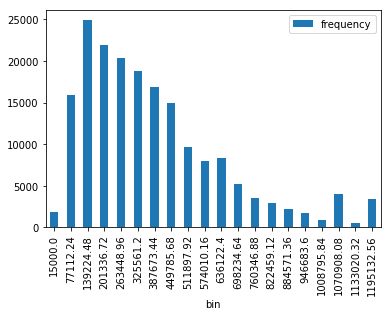

In [40]:
df1 = df.rdd.filter(lambda x: x['SalePrice'] != None)
histogram = df1.map(lambda x: float(x['SalePrice'])).histogram(20)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

When you plot the different features of the model you find that in almost all of the case the data is not normalized as it is distributed with skews. This makes an important case for normalizing the data in order to improve the prediction.

#### Freq. Dist. of Sale Year

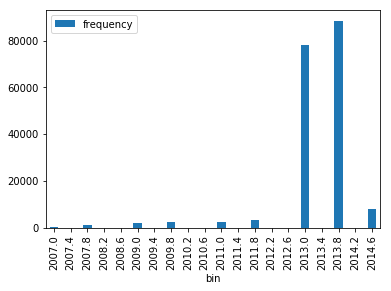

In [39]:
histogram = df.rdd.map(lambda x: float(x['SaleYear'])).histogram(20)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of List Price

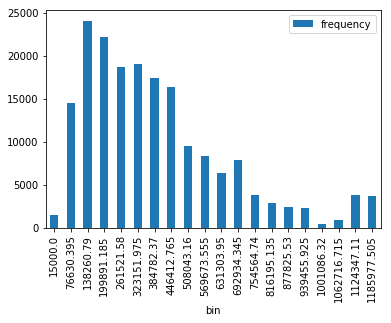

In [78]:
histogram = df.rdd.map(lambda x: float(x['ListPrice'])).histogram(20)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of Bathroom

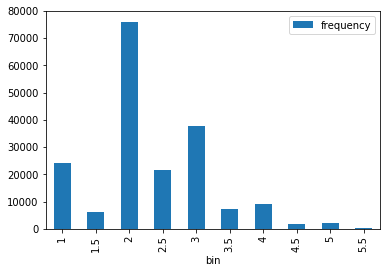

In [85]:
histogram = df.groupBy('Bathroom').count().collect()
histogram = sorted([ (x['Bathroom'], x['count']) for x in histogram])
pd.DataFrame(histogram, columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of Bedroom

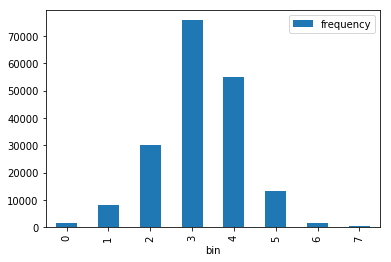

In [86]:
histogram = df.groupBy('Bedroom').count().collect()
histogram = sorted([ (x['Bedroom'], x['count']) for x in histogram])
pd.DataFrame(histogram, columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of Built Year

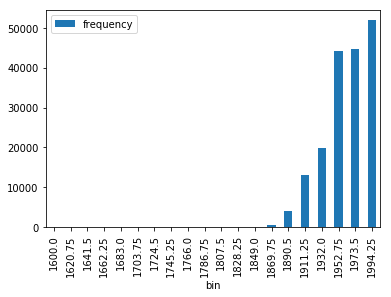

In [105]:
histogram = df.rdd.filter(lambda x: x['BuiltYear'] != "NA").map(lambda x: float(x['BuiltYear'])).histogram(20)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of Build Decade

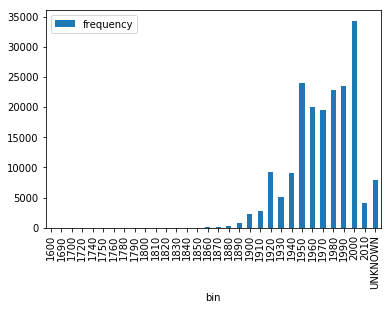

In [98]:
histogram = df.groupBy('BuildDecade').count().collect()
histogram = sorted([ (x['BuildDecade'], x['count']) for x in histogram])
pd.DataFrame(histogram, columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Dist. of Major Renovation

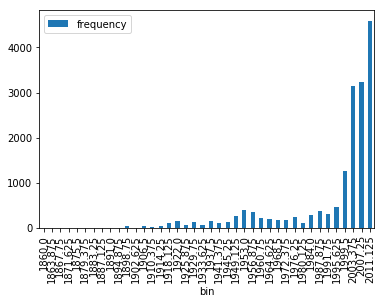

In [6]:
histogram = df.rdd.filter(lambda x: x['MajorRenov'] != "NONE").map(lambda x: float(x['MajorRenov'])).histogram(40)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

#### Freq. Distribution of Finished Sq Feet

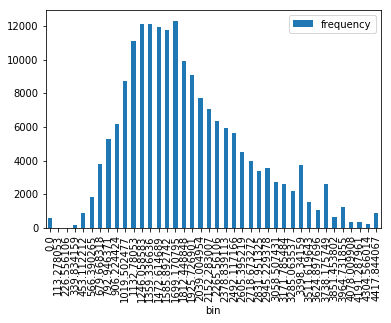

In [5]:
histogram = df.rdd.filter(lambda x: x['FinishSqFt'] != "NONE").map(lambda x: float(x['FinishSqFt'])).histogram(40)
pd.DataFrame(zip(list(histogram)[0],
                     list(histogram)[1]),columns=['bin','frequency']).set_index('bin').plot(kind='bar')

Finally, when you analyze the categorical data you realize that it is pretty uniformly distributed after the first top categories. For instance in the case of the city data you realize that after the top 5 cities the data is uniformly distributed, as well as for the High School data, after the first high school which is a clear outlier the rest is uniformly distributed

#### Freq. Distribution of MSA

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


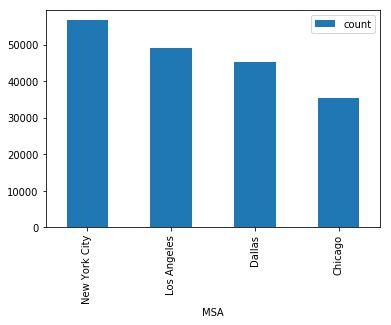

In [30]:
df.groupBy('MSA').count().toPandas().sort(columns = 'count', ascending = False).head(20).plot(y = 'count', x = 'MSA', kind = 'bar')

#### Freq. Distribution of City (Top 25 cities)

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


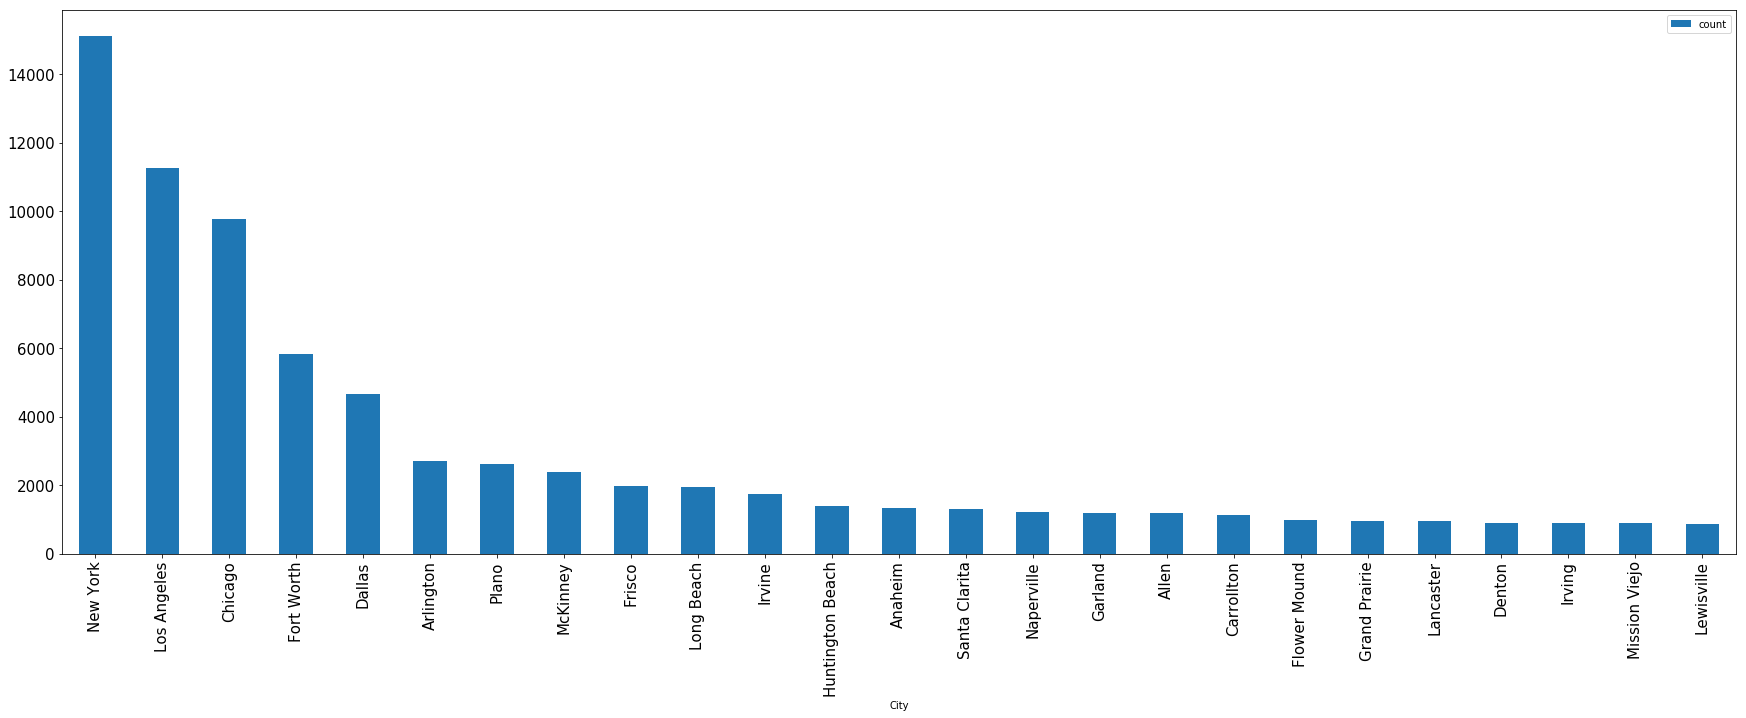

In [41]:
df.groupBy('City').count().toPandas().sort(columns = 'count', ascending = False).head(25).plot(y = 'count',
                                                                                               x = 'City', kind = 'bar',
                                                                                              figsize = (30,10),
                                                                                              fontsize = 15)

#### Freq. Distribution of HighSchool (Top 25 High Schools)

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


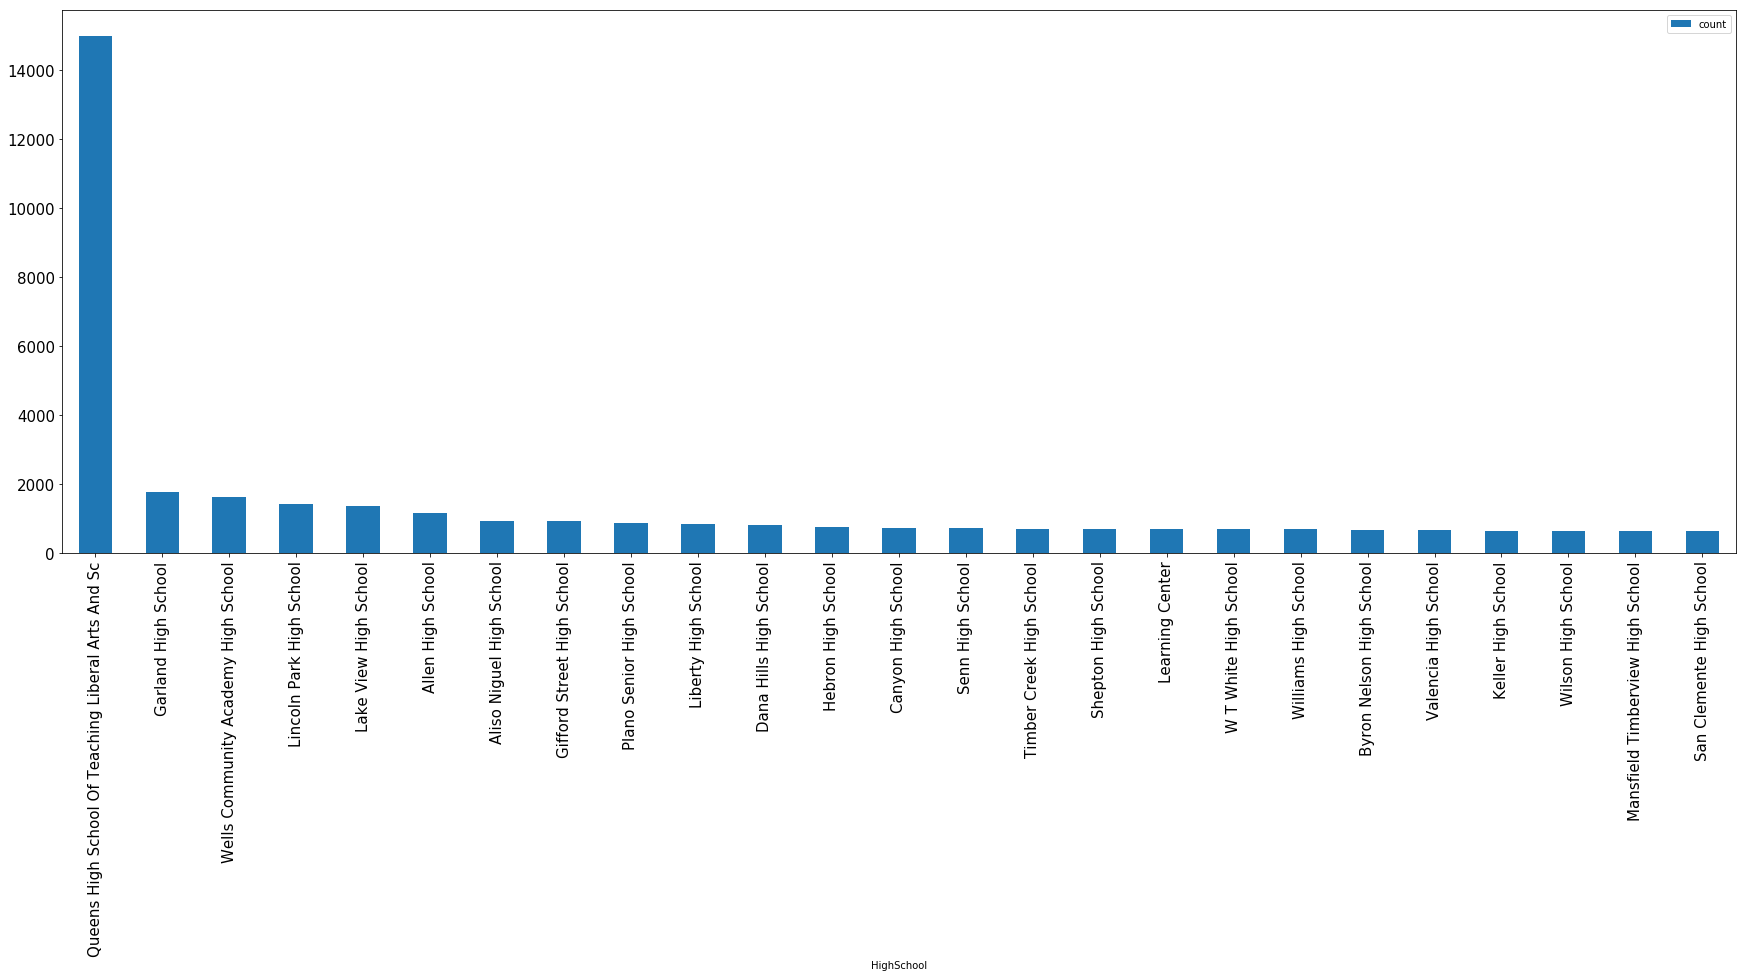

In [42]:
pandas = df.groupBy('HighSchool').count().toPandas()
pandas.ix[pandas.HighSchool != 'NONE', ].sort(columns = 'count', 
                                                 ascending = False).head(25).plot(y = 'count', 
                                                                                  x = 'HighSchool', kind = 'bar',
                                                                                 figsize = (30,10),
                                                                                 fontsize = 15)

Build random forest models to predict SalePrice from the other covariates. You may
use the Spark tools from
https://spark.apache.org/docs/2.1.0/mllib-ensembles.html
The main parameters to vary are numTrees, and maxDepth; these regulate the variance
and bias, respectively. Another parameter is featureSubsetStrategy, which
is the total number of variables allowed in splits; this is aimed at regulating the correlation
between the trees, by introducing randomness

In [4]:
df.show(5)

+-------+---------+----------+---------+--------+--------+-------+---------+-----------+----------+----------+-----------+-------+--------------+--------------------+---------+
|     ID|      Lat|      Long|ListPrice|SaleYear|Bathroom|Bedroom|BuiltYear|BuildDecade|MajorRenov|FinishSqFt|    LotSqFt|    MSA|          City|          HighSchool|SalePrice|
+-------+---------+----------+---------+--------+--------+-------+---------+-----------+----------+----------+-----------+-------+--------------+--------------------+---------+
|3243035|42.145705|-88.138659|    99000|    2012|       2|      2|     1953|       1950|      NONE|      1020|      14344|Chicago|    Barrington|Barrington High S...|    90000|
|3309828|42.095414|-87.901133|   339900|    2014|       2|      3|     1970|       1970|      2013|      1893|       9240|Chicago|Mount Prospect|Wheeling High School|   324000|
|3328383|42.075145|-87.893951|   375000|    2015|       3|      4|       NA|    UNKNOWN|      NONE|      2542|15472

In [46]:

stringIndexer = StringIndexer(inputCol="City", outputCol="CityIndex")
model = stringIndexer.fit(df)
indexed = model.transform(df)

stringIndexer = StringIndexer(inputCol="MSA", outputCol="MSAIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="HighSchool", outputCol="HighSchoolIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="BuiltYear", outputCol="BuiltYearIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="BuildDecade", outputCol="BuildDecadeIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="MajorRenov", outputCol="MajorRenovIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

indexed = indexed.rdd.filter(lambda x: x['SalePrice'] != None)

In [47]:
data = indexed.map(lambda x: (x["SalePrice"], [x["Lat"], x["Long"], x["ListPrice"], x["SaleYear"], x["Bathroom"], 
                                           x["Bedroom"], x["BuiltYearIndex"], x["BuildDecadeIndex"], x["MajorRenovIndex"],
                                           x["FinishSqFt"], x["LotSqFt"], x['CityIndex'], x["MSAIndex"], 
                                           x["HighSchoolIndex"]])).map(lambda x: LabeledPoint(x[0], x[1]))

In [60]:
for row in proof:
    if not isinstance(row[0], (str, float, int, unicode)):
        print row
    for e in row[1]:
        if not isinstance(e, (str, float, int, unicode)):
            print row
        

In [48]:

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.70, 0.30])


We trained several models in order to check which were the ones having the best results, our conclusion is that trees that have high max depth and high number of trees are doing much better than those with low of both, this is because of the fact that max depth reduces bias and num of trees variance

We first trained a model with 5 trees and 5 nodes of depth, with really lousy results

In [49]:
model_trained_1 = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
numTrees=5, featureSubsetStrategy='auto',
impurity='variance', maxDepth=5, maxBins=100)

predictions = model_trained_1.predict(testData.map(lambda x: x.features))
labels = testData.map(lambda x:x.label)

metrics2 = RegressionMetrics(predictions.zip(labels))

print("Mean Squared Error: %s" % metrics2.meanSquaredError)

print("Mean Absolute Error: %s" % metrics2.meanAbsoluteError)

Mean Squared Error: 4964288589.1
Mean Absolute Error: 50138.7615871


Next, we trained a model with 15 trees which improved but still was lagging accuracy

In [50]:
model_trained_1 = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
numTrees=15, featureSubsetStrategy='auto',
impurity='variance', maxDepth=5, maxBins=100)

predictions = model_trained_1.predict(testData.map(lambda x: x.features))
labels = testData.map(lambda x:x.label)

metrics2 = RegressionMetrics(predictions.zip(labels))

print("Mean Squared Error: %s" % metrics2.meanSquaredError)

print("Mean Absolute Error: %s" % metrics2.meanAbsoluteError)

Mean Squared Error: 2872295417.18
Mean Absolute Error: 37897.6995491


A model with higher depth was being better at reducing the mean absolute error

In [51]:
model_trained_1 = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
numTrees=5, featureSubsetStrategy='auto',
impurity='variance', maxDepth=15, maxBins=100)

predictions = model_trained_1.predict(testData.map(lambda x: x.features))
labels = testData.map(lambda x:x.label)

metrics2 = RegressionMetrics(predictions.zip(labels))

print("Mean Squared Error: %s" % metrics2.meanSquaredError)

print("Mean Absolute Error: %s" % metrics2.meanAbsoluteError)

Mean Squared Error: 277405123.442
Mean Absolute Error: 11148.243873


A model with both medium depth and number of trees was predicting even better

In [52]:
model_trained_1 = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
numTrees=15, featureSubsetStrategy='auto',
impurity='variance', maxDepth=15, maxBins=100)

predictions = model_trained_1.predict(testData.map(lambda x: x.features))
labels = testData.map(lambda x:x.label)

metrics2 = RegressionMetrics(predictions.zip(labels))

print("Mean Squared Error: %s" % metrics2.meanSquaredError)

print("Mean Absolute Error: %s" % metrics2.meanAbsoluteError)

Mean Squared Error: 239317070.747
Mean Absolute Error: 10169.0292222


In the end, we chose a model with 50 trees and 20 nodes as max depth. This model showed a really small MAE of 9,300 which is small considering the average sale price is of around 380,000

In [48]:
# Train a RandomForest model.
# Empty categoricalFeaturesInfo indicates all features are continuous.
# Note: Use larger numTrees in practice.
# Setting featureSubsetStrategy=’’auto’’ lets the algorithm choose.
model_trained = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
numTrees=50, featureSubsetStrategy='auto',
impurity='variance', maxDepth=20, maxBins=100)

In [49]:
predictions = model_trained.predict(testData.map(lambda x: x.features))

In [50]:
labels = testData.map(lambda x:x.label)

In [30]:
predictions.zip(labels)

org.apache.spark.api.java.JavaPairRDD@37338595

In [51]:
metrics2 = RegressionMetrics(predictions.zip(labels))

print("Mean Squared Error: %s" % metrics2.meanSquaredError)

print("Mean Absolute Error: %s" % metrics2.meanAbsoluteError)

Mean Squared Error: 200524853.559
Mean Absolute Error: 9396.06894068


Finally, using your best regression model, predict the sale prices for the houses given in
the test data we have prepared, /project/cmsc25025/zillow/zillow-test.csv.
Note that the SalePrice response has been replace by *. Replace this character with
your predicted value, keeping all of the other attributes in the csv. Submit this file as
assn6 prob3 predict.csv.

In [41]:
df_val = spark.read.csv('/project/cmsc25025/zillow/zillow-test.csv', header=True)


In [42]:
df_val.show(1)

+--------+---------+----------+-----------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+--------+--------------------+---------+
|      ID|      Lat|      Long|  ListPrice|SaleYear|Bathroom|Bedroom|BuiltYear|BuildDecade|MajorRenov|FinishSqFt|LotSqFt|    MSA|    City|          HighSchool|SalePrice|
+--------+---------+----------+-----------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+--------+--------------------+---------+
|61960407|41.867103|-87.774551|178892.3927|    2009|       1|      2|     1926|       1920|      NONE|      1200|   5597|Chicago|Oak Park|Oak Park & River ...|        *|
+--------+---------+----------+-----------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+--------+--------------------+---------+
only showing top 1 row



In [44]:
stringIndexer = StringIndexer(inputCol="City", outputCol="CityIndex")
model = stringIndexer.fit(df_val)
indexed = model.transform(df_val)

stringIndexer = StringIndexer(inputCol="MSA", outputCol="MSAIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="HighSchool", outputCol="HighSchoolIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="BuiltYear", outputCol="BuiltYearIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="BuildDecade", outputCol="BuildDecadeIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

stringIndexer = StringIndexer(inputCol="MajorRenov", outputCol="MajorRenovIndex")
model = stringIndexer.fit(indexed)
indexed = model.transform(indexed)

In [52]:
val_data = indexed.rdd.map(lambda x: (x["Bedroom"], [x["Lat"], x["Long"], x["ListPrice"], x["SaleYear"], x["Bathroom"], 
                                           x["Bedroom"], x["BuiltYearIndex"], x["BuildDecadeIndex"], x["MajorRenovIndex"],
                                           x["FinishSqFt"], x["LotSqFt"], x['CityIndex'], x["MSAIndex"], 
                                           x["HighSchoolIndex"]])).map(lambda x: LabeledPoint(x[0], x[1]))

In [54]:
predictions = model_trained.predict(val_data.map(lambda x: x.features))

In [57]:
pred_vector = predictions.collect()

Moving it to a csv

In [62]:
val_pandas = df_val.toPandas()

In [63]:
val_pandas.SalePrice = pred_vector

In [64]:
val_pandas.head()

,ID,Lat,Long,ListPrice,SaleYear,Bathroom,Bedroom,BuiltYear,BuildDecade,MajorRenov,FinishSqFt,LotSqFt,MSA,City,HighSchool,SalePrice
0,61960407,41.867103,-87.774551,178892.3927,2009,1,2,1926,1920,NONE,1200,5597,Chicago,Oak Park,Oak Park & River Forest High School,172769.450307
1,3345585,42.107464,-87.778617,478511,2014,2,3,1957,1950,NONE,1578,9454,Chicago,Northfield,New Trier Township H S Winnetka,456863.627994
2,3483598,42.044651,-87.888992,89900,2013,1,1,NA,UNKNOWN,NONE,925,5248.5,Chicago,Des Plaines,Maine West High School,86217.281264
3,3583003,41.97145,-87.831476,424900,2014,3,7,1951,1950,NONE,3456,13068,Chicago,Norridge,Ridgewood Community High School,400521.766299
4,3590178,41.963699,-87.832438,219900,2013,1,3,1953,1950,NONE,1017,5140,Chicago,Norridge,Ridgewood Community High School,212747.760143


In [69]:
val_pandas.to_csv("assn6_prob3_predict.csv")